## Root Mean Square Distance Calculations

In [1]:
import mdtraj as md
import itertools

import numpy as np

import pandas as pd

from pathlib import Path

import seaborn as sns

import soursop as ss
from soursop.sstrajectory import SSTrajectory
NA_EXTENSION = ['D5P', 'DPC',  'DPU',  'DPT',  'DPA',  'DPG',  'R5P',  'RPC' , 'RPU',  'RPT',  'RPA',  'RPG']

# importing mean()
from statistics import mean

def Average(lst):
    return mean(lst)

import matplotlib.pyplot as plt

import itertools
colors = ['#747FE3']
colors2 = ['#E37346']
sns.set_palette(sns.color_palette(colors))


Bad key "text.kerning_factor" on line 4 in
/home/alstonj/miniconda3/envs/labconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#define distance cutoff to be 6 ang
dc = 6

In [3]:
"""
We want to build a dictionary that is able to access each lammps_fixed_traj.pdb/equilibrated.xtc for each RNA length + NTDRBD. 
We make a mdtraj object for each simulation.
We calculate the pairwise distances for NTD and RNA
Then we make nested dictionaries that contain values that are bound and unbound and correspond to frames that have a
value corresponding to less than our distance cutoff
"""

traj_dict = {}
for i in [25]:
                   
    traj_dict['system_%i'%(i)] = None  
    prefix = '/work/alstonj/supportingdata/2022/cubuk_et_al_2022/data'
    xtcfilename = prefix+ '/equilibrated_traj.xtc'
    pdbfilename = prefix + '/lammps_fixed_traj.pdb'
    MDTD = md.load(xtcfilename, top = pdbfilename)
    traj_dict['system_%i'%(i)] = {}
    traj_dict['system_%i'%(i)]['SST'] = MDTD
    print(i)

    #Group 1 is the RNA nts

    group_1 = [nucleotide + 173 for nucleotide in range(i)]
    #print(group_1)

    #Group 2 is the NTD, this is always 68nts

    group_2 = [aminoacid for aminoacid in range(68)]
    #print(group_2)

    pairs = list(itertools.product(group_1, group_2))
    #len(pairs)

    #compute the pairwise distance for every frame 
    cc = md.compute_contacts(traj_dict['system_%i'%(i)]['SST'], pairs, ignore_nonprotein = False)

    bound = []
    unbound = []

    for a in range(len(traj_dict['system_%i'%(i)]['SST'])):
        if any(a <= dc for a in cc[0][a]):
            bound.append(a)
            #print(a)
            if a % 10000 == 0:
                print('bound', a)

        else:
            unbound.append(a)
            #print(a)
            if a % 10000 == 0:
                print('unbound', a)


    print(traj_dict['system_%i'%(i)]['SST'])

    traj_dict['system_%i'%(i)]['Bound'] = bound
    traj_dict['system_%i'%(i)]['UnBound'] = unbound
    print(len(bound))
    print(len(unbound))


    bound_df = pd.DataFrame.from_dict(data=traj_dict['system_%i'%(i)]['Bound'])

    bound_df.to_csv(prefix + '/bound_frames.csv', header=False)

    unbound_df = pd.DataFrame.from_dict(data=traj_dict['system_%i'%(i)]['UnBound'])

    unbound_df.to_csv(prefix + '/unbound_frames.csv', header=False)



25
unbound 0
<mdtraj.Trajectory with 2985 frames, 198 atoms, 198 residues, and unitcells>
2330
655


In [4]:
#Replicates = a, for test this is 1

for a in [1]:
    
#RNA Lengths, so you can analyze in batch, but for test this is 25nt
    for i in [25]:
        traj_dict['%i_system_%i'%(i,a)] = {}
        traj_dict['%i_system_%i'%(i,a)]['Bound'] = pd.read_csv(prefix+'/bound_frames.csv', header = None)
        print(traj_dict['%i_system_%i'%(i,a)]['Bound'])
        traj_dict['%i_system_%i'%(i,a)]['UnBound'] = pd.read_csv(prefix+'/unbound_frames.csv', header = None)
        print(traj_dict['%i_system_%i'%(i,a)]['UnBound'])

         0     1
0        0     9
1        1    10
2        2    48
3        3    71
4        4    72
...    ...   ...
2325  2325  2980
2326  2326  2981
2327  2327  2982
2328  2328  2983
2329  2329  2984

[2330 rows x 2 columns]
       0     1
0      0     0
1      1     1
2      2     2
3      3     3
4      4     4
..   ...   ...
650  650  2167
651  651  2168
652  652  2169
653  653  2171
654  654  2172

[655 rows x 2 columns]


In [5]:
#Generate the SST for each RNA:Protein and store in a corresponding dict

for a in [1]:
    for i in [25]:
        #print(i)
        prefix = '/work/alstonj/supportingdata/2022/cubuk_et_al_2022/data'
        xtcfilename = prefix+ '/equilibrated_traj.xtc'
        pdbfilename = prefix + '/lammps_fixed_traj.pdb'
        SST = SSTrajectory(xtcfilename, pdbfilename,extra_valid_residue_names=NA_EXTENSION)
        traj_dict['%i_protein_%i_all'%(i,a)] = {}
        traj_dict['%i_protein_%i_all'%(i,a)]['SST'] = SST
        print(SST.n_frames)
        traj_dict['%i_protein_%i'%(i,a)] = {}
        traj_dict['%i_protein_%i'%(i,a)]['SST'] = SST.proteinTrajectoryList[0]
        print(traj_dict['%i_protein_%i'%(i,a)]['SST'])
        traj_dict['%i_rna_%i'%(i,a)] = {}
        traj_dict['%i_rna_%i'%(i,a)]['SST'] = SST.proteinTrajectoryList[1]

2985
SSProtein (0x7f444d4cb9e8): 173 res and 2985 frames


In [6]:
#Calculate the IRD of NTD for the frames that are bound/unbound

for a in [1]:
    for i in [25]:
    
        IRD = traj_dict['%i_protein_%i'%(i,a)]['SST'].get_inter_residue_COM_distance(R1=1, R2=68)

        traj_dict['%i_system_%i'%(i,a)]['IRD_Bound'] = [IRD[a] for a in traj_dict['%i_system_%i'%(i,a)]['Bound'][1]]
        traj_dict['%i_system_%i'%(i,a)]['IRD_UnBound'] = [IRD[a] for a in traj_dict['%i_system_%i'%(i,a)]['UnBound'][1]]
        dfBound = pd.DataFrame.from_dict(traj_dict['%i_system_%i'%(i,a)]['IRD_Bound'])
        dfBound.to_csv ('/work/alstonj/supportingdata/2022/cubuk_et_al_2022/data/Bound_nt%i_r%i.csv'%(i,a), index = False)
        dfUnBound = pd.DataFrame.from_dict(traj_dict['%i_system_%i'%(i,a)]['UnBound'])
        dfUnBound.to_csv ('/work/alstonj/supportingdata/2022/cubuk_et_al_2022/data/Unbound_nt%i_r%i.csv'%(i,a), index = False)
        print(i)

25


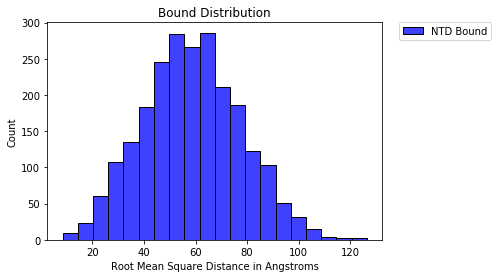

The average NTD IRD when bound is 58.462962264124975
Root Mean Square Distance when Bound is: 61.45610686508 in Ang


In [13]:
#Check the distribution's of the bound state

plt.xlabel("Root Mean Square Distance in Angstroms")
plt.title('Bound Distribution')

for a in [1]:
    for i in [25]:
        sns.histplot(traj_dict['%i_system_%i'%(i,a)]['IRD_Bound'], bins = 20,label = "NTD Bound", color = 'Blue')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        print('The average NTD IRD when bound is', Average(traj_dict['%i_system_%i'%(i,a)]['IRD_Bound']))
        power = [ x**2 for x in traj_dict['%i_system_%i'%(i,a)]['IRD_Bound'] ]
        
        rms = np.sqrt(Average((power)))
        print('Root Mean Square Distance when Bound is:', rms, 'in Ang')

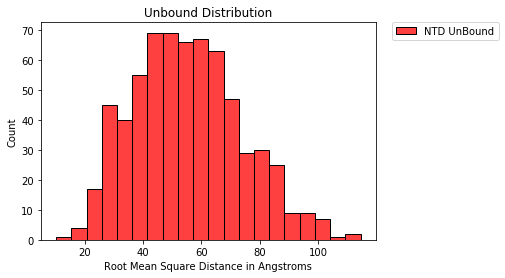

The average NTD IRD when Unbound is 55.18181400144078
Root Mean Square Distance when Bound is: 58.1444543826063 in Ang


In [11]:
#Check the distribution's of the unbound state

plt.xlabel("Root Mean Square Distance in Angstroms")
plt.title('Unbound Distribution')


for a in [1]:
    for i in [25]:
        sns.histplot(traj_dict['%i_system_%i'%(i,a)]['IRD_UnBound'], bins = 20, label = "NTD UnBound", color = 'Red')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        print('The average NTD IRD when Unbound is', Average(traj_dict['%i_system_%i'%(i,a)]['IRD_UnBound']))
        power = [ x**2 for x in traj_dict['%i_system_%i'%(i,a)]['IRD_UnBound'] ]
        
        rms = np.sqrt(Average((power)))
        print('Root Mean Square Distance when Bound is:', rms, 'in Ang')

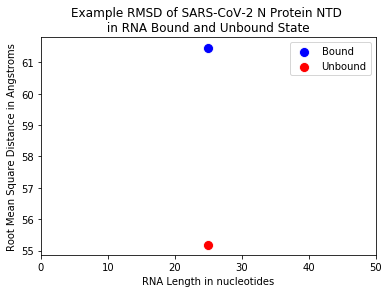

In [14]:
#Make lists to store distances in bound and unbound state

Bound_distance = []
Unbound_distance = []

#Make Lists to store corresponding RNA lengths for plotting

#Bound RNA
RNA = []

#Unbound RNA
RNAu = []

plt.xlim(0,50)
plt.xlabel("RNA Length in nucleotides")
plt.ylabel("Root Mean Square Distance in Angstroms")
plt.title('Example RMSD of SARS-CoV-2 N Protein NTD \n in RNA Bound and Unbound State ')


for a in [1]:
    for nt_length in [25]:
        power = [ x**2 for x in traj_dict['%i_system_%i'%(nt_length,a)]['IRD_Bound'] ]
        
        rms = np.sqrt(Average((power)))
        
        Bound_distance.append(rms)
        Unbound_distance.append(Average(traj_dict['%i_system_%i'%(nt_length,a)]['IRD_UnBound']))
        RNA.append(i)
        RNAu.append(i)
        

sns.scatterplot(x = RNA, y = Bound_distance, color= 'Blue', s = 100, label = "Bound")
sns.scatterplot(x = RNAu, y = Unbound_distance, color= 'Red', s = 100, label = "Unbound")